In [2]:
import sys
import os

notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
project_root = os.path.dirname(project_root)
sys.path.append(project_root)
from data import preprocess, feature_extraction


Import libraries

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree


MAX_GRAM = 3
MAX_FEATURES = 50000

Data preprocessing

In [4]:
# Initialize preprocessing object
pre_proc = preprocess.Preprocessing()

# Read data from CSV file
data = pre_proc.read_CSV('test.csv')

# Apply preprocessing to text column
data['processed_text'] = data['text'].apply(pre_proc.preprocess)

# View dataset info
data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, 0 to 3533
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
 9   processed_text    3534 non-null   object 
dtypes: float64(3), object(7)
memory usage: 303.7+ KB


Splitting the dataset

In [5]:
# Separate features (X) and labels (y)
X = data['processed_text']
y = data['sentiment']

# Split into train/val/test sets
feature_extract = feature_extraction.FeatureExtraction()
X_train, X_val, X_test, y_train, y_val, y_test = feature_extract.split_dataset(X, y)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of test samples: {len(X_test)}")


Number of training samples: 2827
Number of test samples: 354


Feature extraction using TF-IDF

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1,MAX_GRAM), max_features= MAX_FEATURES)

# Convert text into vector representations
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

print("TF-IDF vector shape (train set):", X_train_vectors.shape)
print("TF-IDF vector shape (test set):", X_test_vectors.shape)


TF-IDF vector shape (train set): (2827, 35915)
TF-IDF vector shape (test set): (354, 35915)


Train Decision Tree model

In [7]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_vectors, y_train)

DecisionTreeClassifier()

Make predictions & evaluate performance

In [8]:
# Making predictions on the test set
y_pred = dt_classifier.predict(X_test_vectors)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute F1-score (weighted to account for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))


Accuracy: 0.6016949152542372
F1-score: 0.6027144131515229
              precision    recall  f1-score   support

    negative       0.59      0.53      0.56       100
     neutral       0.55      0.63      0.58       143
    positive       0.71      0.63      0.67       111

    accuracy                           0.60       354
   macro avg       0.61      0.60      0.60       354
weighted avg       0.61      0.60      0.60       354



Display confusion matrix

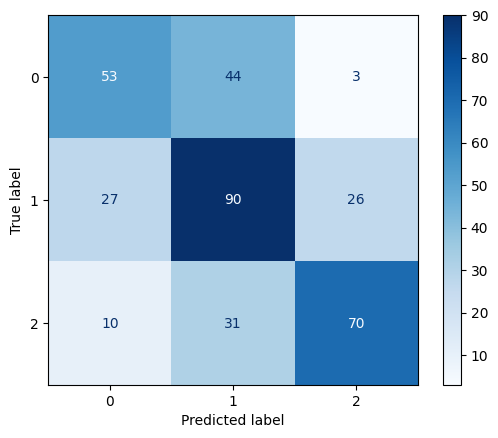

In [9]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
